# Future Sales Prediction

## Dependencies and Reading data

In [1]:
import datetime
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import mglearn

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from  sklearn.linear_model import Ridge
from  sklearn.linear_model import Lasso
from  sklearn.preprocessing  import PolynomialFeatures
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

%matplotlib inline
sns.set(style="darkgrid")
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

In [2]:
item_categories = pd.read_csv('../Data/item_categories.csv', 
                              dtype={'item_category_name': 'str', 'item_category_id': 'int32'})
items = pd.read_csv('../Data/items.csv', dtype={'item_name': 'str', 'item_id': 'int32', 
                                                 'item_category_id': 'int32'})
sales_train = pd.read_csv('../Data/sales_train_v2.csv', parse_dates=['date'], 
                    dtype={'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 
                          'item_id': 'int32', 'item_price': 'float32', 'item_cnt_day': 'int32'})
shops = pd.read_csv('../Data/shops.csv', dtype={'shop_name': 'str', 'shop_id': 'int32'})
test = pd.read_csv('../Data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 
                                                  'item_id': 'int32'})


## Joining the data sets

In [3]:
train = sales_train.join(items, on='item_id', rsuffix='_').join(shops, on='shop_id', rsuffix='_').join(item_categories, on='item_category_id', rsuffix='_').drop(['item_id_', 'shop_id_', 'item_category_id_'], 
                                                                axis=1)

In [4]:
train.shape

(2935849, 10)

In [5]:
train.head().T

,0,1,2,3,4
date,2013-02-01 00:00:00,2013-03-01 00:00:00,2013-05-01 00:00:00,2013-06-01 00:00:00,2013-01-15 00:00:00
date_block_num,0,0,0,0,0
shop_id,59,25,25,25,25
item_id,22154,2552,2552,2554,2555
item_price,999.00,899.00,899.00,1709.05,1099.00
item_cnt_day,1,1,-1,1,1
item_name,ЯВЛЕНИЕ 2012 (BD),DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE The House Of Blue Light LP,DEEP PURPLE Who Do You Think We Are LP,DEEP PURPLE 30 Very Best Of 2CD (Фирм.)
item_category_id,37,58,58,58,56
shop_name,"Ярославль ТЦ ""Альтаир""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум""","Москва ТРК ""Атриум"""
item_category_name,Кино - Blu-Ray,Музыка - Винил,Музыка - Винил,Музыка - Винил,Музыка - CD фирменного производства


In [6]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,item_category_id
count,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00,2935849.00
mean,14.57,33.00,10197.23,890.62,1.24,40.00
std,9.42,16.23,6324.30,1726.44,2.62,17.10
min,0.00,0.00,0.00,-1.00,-22.00,0.00
25%,7.00,22.00,4476.00,249.00,1.00,28.00
50%,14.00,31.00,9343.00,399.00,1.00,40.00
75%,23.00,47.00,15684.00,999.00,1.00,55.00
max,33.00,59.00,22169.00,307980.00,2169.00,83.00


## Data Preprocessing

##### Dropping Text features as they are in Russian and we can't process them.

In [7]:
train = train[['date','date_block_num', 'shop_id', 'item_id', 'item_price', 'item_cnt_day',
               'item_category_id']]

##### We want to predict the sales for shops and items at a monthly level. The data we have now is day-to-day data. So, we need to aggregate the data by month.

In [8]:
train_monthly = train.sort_values('date').groupby(['date_block_num', 'shop_id', \
'item_category_id', 'item_id'], as_index=False)

In [9]:
train_monthly = train_monthly.agg({'item_price':['sum', 'mean'], 
                                   'item_cnt_day':['sum', 'mean','count']})

In [10]:
# Rename features.
train_monthly.columns = ['date_block_num', 'shop_id', 'item_category_id', 
                         'item_id', 'item_price', 'mean_item_price', 'item_cnt',
                         'mean_item_cnt', 'transactions']

##### Test and Train data sets should have same shop IDs and item IDs for us to predict the future sales based on historic data.

In [11]:
#Filtering out of unique shop and item ID's from the test dataset
shopid_test = test['shop_id'].unique()
itemid_test = test['item_id'].unique()

In [12]:
#Filtering out shop and item IDs that are not present in test dataset from the train dataset
train_monthly = train_monthly[train_monthly['shop_id'].isin(shopid_test)]
train_monthly = train_monthly[train_monthly['item_id'].isin(itemid_test)]

In [13]:
train_monthly.shape[0]

600159

##### For every month out of the 33 months present in our dataset, we need a record for all shops and items. This is not the case with the data available, so we will create the records in all possible combinations of month, shop and item. Since the information for the created records will be missing, we need to fill them with 0.

In [14]:
#Filtering out unique shop and item IDs from train dataset to use them to build a new dataframe
#This new dataframe will have records that encompass all possible combinations of month, shop and item IDs
shopid_train = train_monthly['shop_id'].unique()
itemid_train = train_monthly['item_id'].unique()
updated_train = []

In [15]:
for i in range(34):
    for shop in shopid_train:
        for item in itemid_train:
            updated_train.append([i, shop, item])
            
updated_train_df = pd.DataFrame(updated_train, columns=['date_block_num','shop_id','item_id'])

In [16]:
#Merging the updated dataframe with the original train dataframe
train_monthly = pd.merge(updated_train_df, train_monthly, on = ['date_block_num','shop_id','item_id'], how = 'left')

In [17]:
#Filling missing records with 0
train_monthly.fillna(0, inplace=True)

In [18]:
train_monthly.shape

(6734448, 9)

In [19]:
train_monthly.head

<bound method NDFrame.head of          date_block_num  shop_id  item_id  item_category_id  item_price  \
0                     0        2     5572              2.00    10730.00   
1                     0        2     5643              2.00     4775.21   
2                     0        2     5583              5.00     1188.30   
3                     0        2     7893              6.00     5970.00   
4                     0        2     7894              6.00     1490.00   
5                     0        2     7895              6.00     2697.00   
6                     0        2     7956              6.00    13780.00   
7                     0        2     1409             19.00     1398.50   
8                     0        2     1467             19.00      899.00   
9                     0        2     3076             19.00     1399.00   
10                    0        2     3316             19.00     2398.00   
11                    0        2     3686             19.00     3595.5

In [20]:
# Extract time based features.
train_monthly['year'] = train_monthly['date_block_num'].apply(lambda x: ((x//12) + 2013))
train_monthly['month'] = train_monthly['date_block_num'].apply(lambda x: (x % 12))

In [21]:
#Grouping Data by month 
month_item_cnt_sum = train_monthly.groupby(['month'], as_index=False)['item_cnt'].sum()
month_item_cnt_mean = train_monthly.groupby(['month'], as_index=False)['item_cnt'].mean()

Monthly mean item sales and total items sold per month over the year

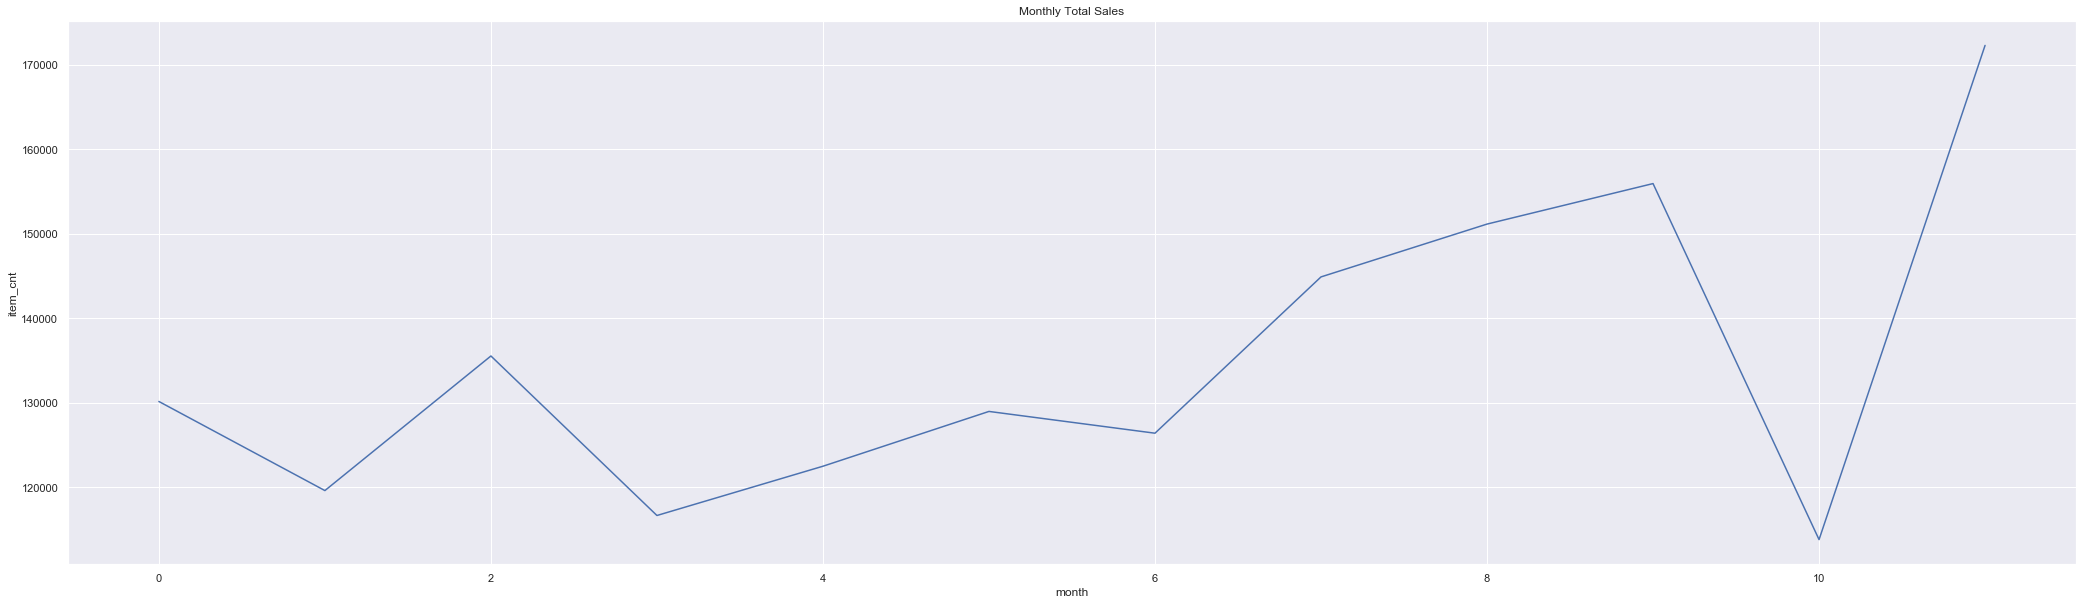

In [22]:
plt.figure(figsize=(36,10))
sns.lineplot(x="month", y="item_cnt", data=month_item_cnt_sum).set_title("Monthly Total Sales")
plt.show()

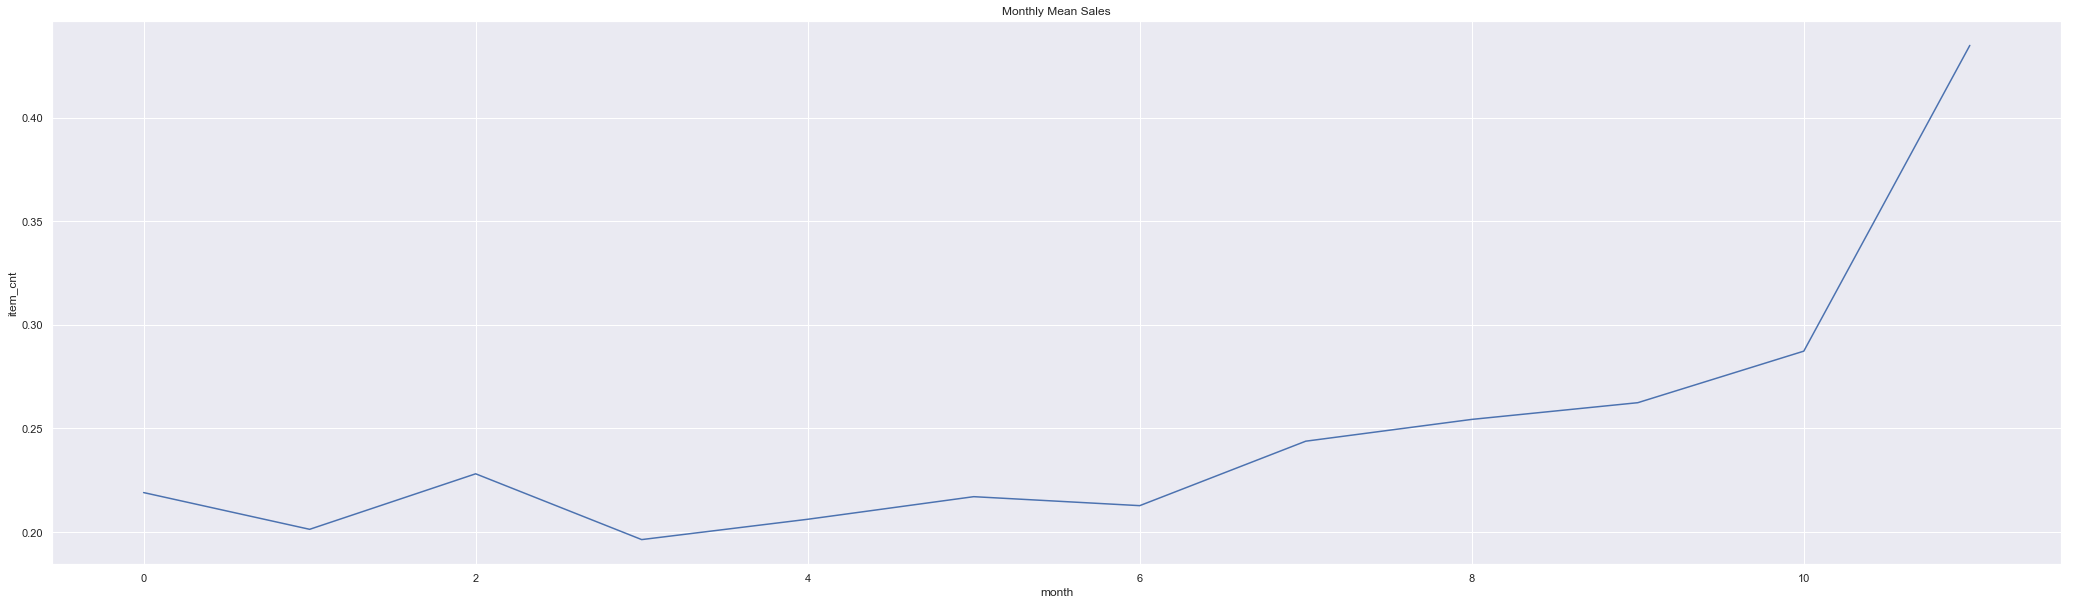

In [23]:
plt.figure(figsize=(36,10))
sns.lineplot(x="month", y="item_cnt", data=month_item_cnt_mean).set_title("Monthly Mean Sales")
plt.show()

In [24]:
#Grouping data by shop_id
shop_item_cnt_sum = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].sum()
shop_item_cnt_mean = train_monthly.groupby(['shop_id'], as_index=False)['item_cnt'].mean()

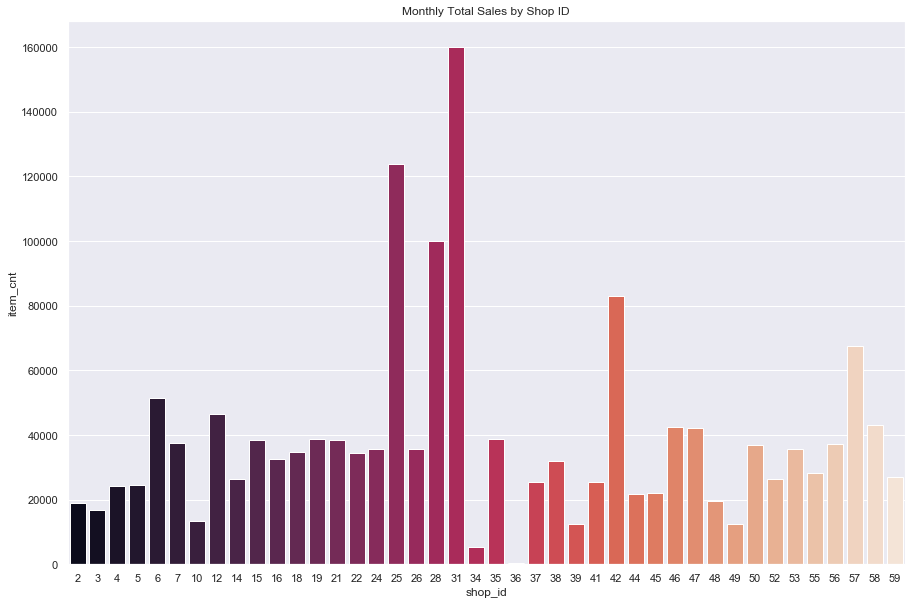

In [25]:
plt.figure(figsize=(15,10))
sns.barplot(x="shop_id", y="item_cnt", data=shop_item_cnt_sum, palette="rocket").set_title("Monthly Total Sales by Shop ID")
plt.show()

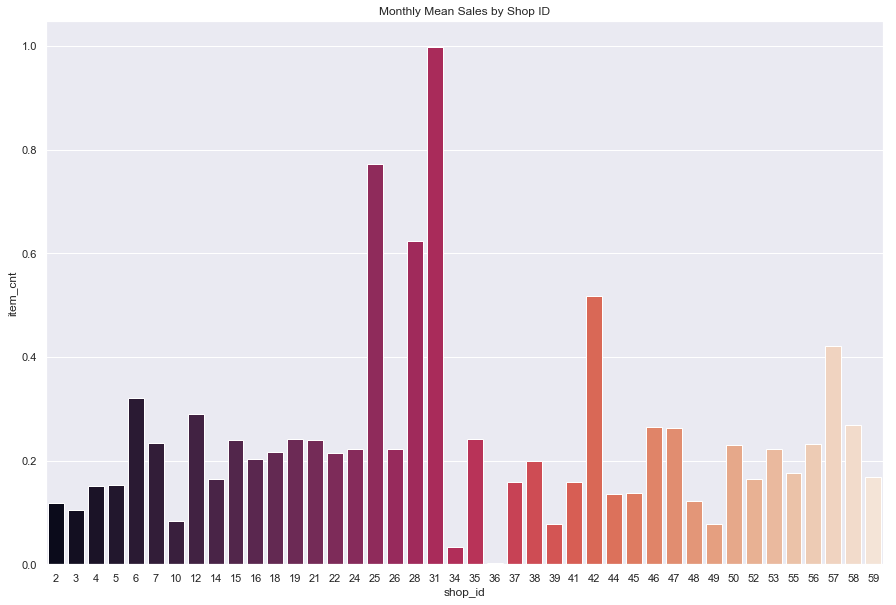

In [26]:
plt.figure(figsize=(15,10))
sns.barplot(x="shop_id", y="item_cnt", data=shop_item_cnt_mean, palette="rocket").set_title("Monthly Mean Sales by Shop ID")
plt.show()

In [27]:
#Grouping Data by item_category
cat_item_cnt_sum = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].sum()
cat_item_cnt_mean = train_monthly.groupby(['item_category_id'], as_index=False)['item_cnt'].mean()

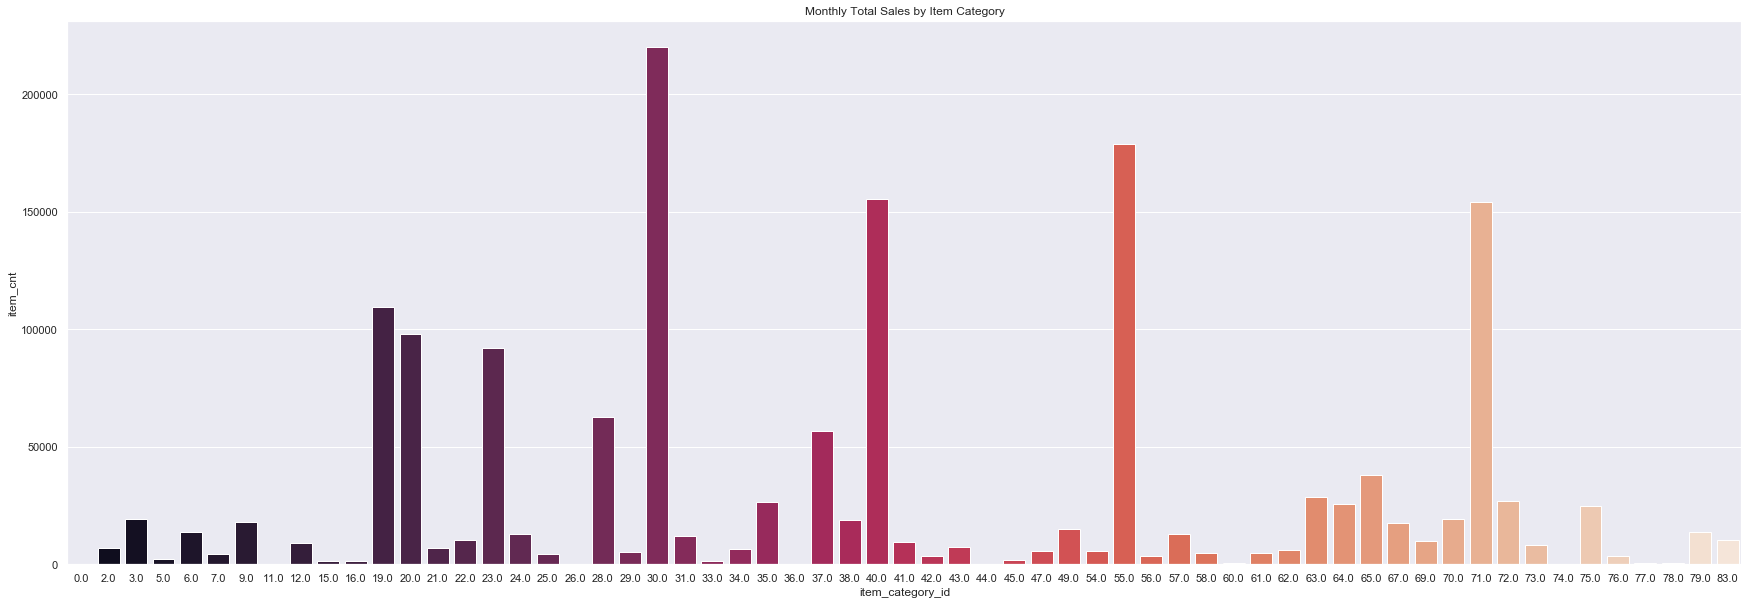

In [28]:
plt.figure(figsize=(30,10))
sns.barplot(x="item_category_id", y="item_cnt", data=cat_item_cnt_sum, palette="rocket").set_title("Monthly Total Sales by Item Category")
plt.show()

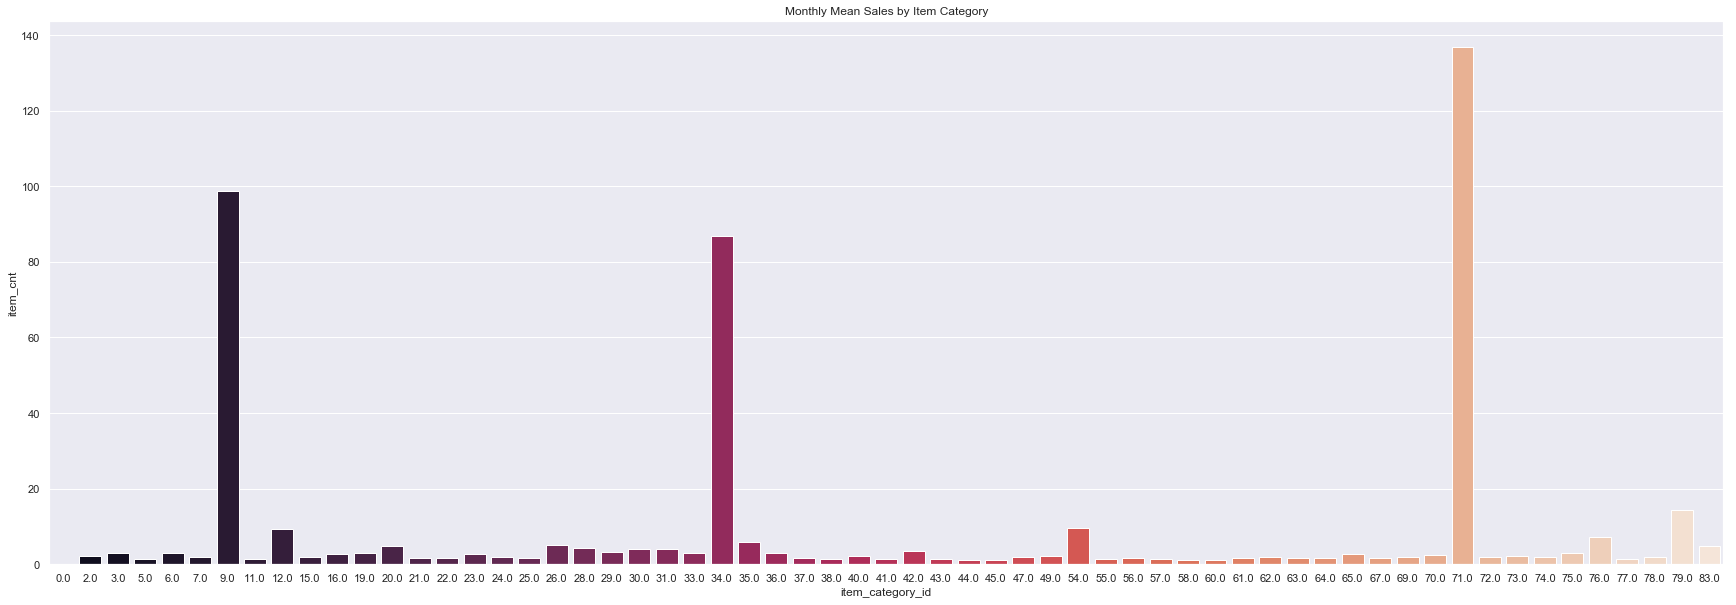

In [29]:
plt.figure(figsize=(30,10))
sns.barplot(x="item_category_id", y="item_cnt", data=cat_item_cnt_mean, palette="rocket").set_title("Monthly Mean Sales by Item Category")
plt.show()

## Checking for outliers

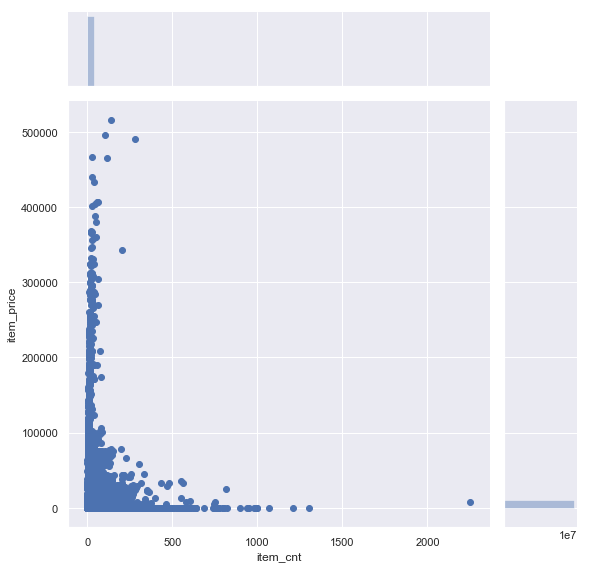

In [30]:
sns.jointplot(x="item_cnt", y="item_price", data=train_monthly, height=8)
plt.show()

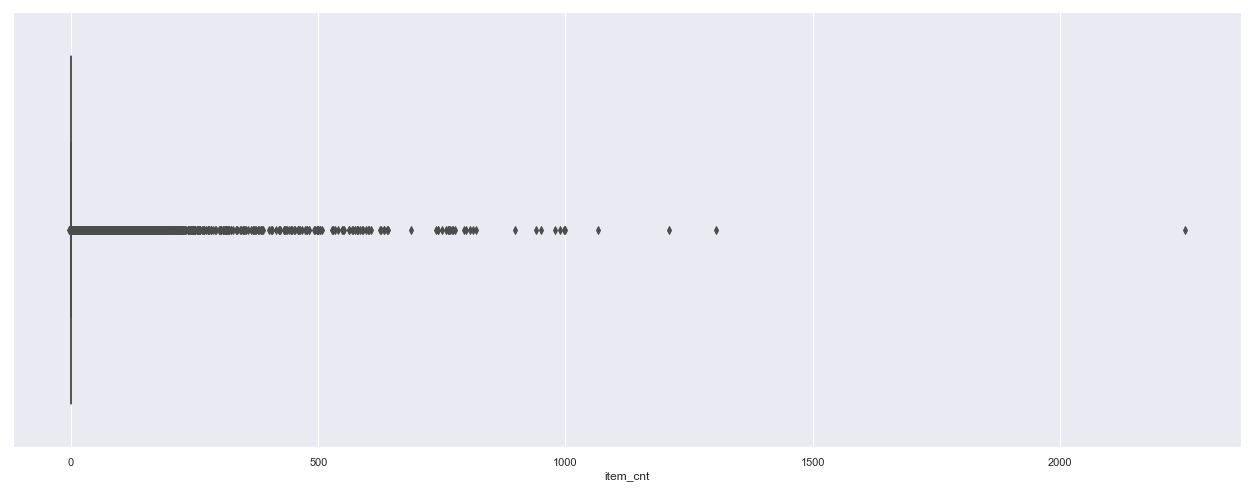

In [31]:
#item_cnt distribution
plt.subplots(figsize=(22, 8))
sns.boxplot(train_monthly['item_cnt'])
plt.show()

## Removing outliers

In [32]:
train_monthly = train_monthly.query('item_cnt >= 0 and item_cnt <= 20 and item_price < 400000')

## Creating the label

Our label will be the "item_cnt" of the next month, as we are dealing with a forecast problem.

In [33]:
train_monthly['item_cnt_month'] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

By this item_cnt for each grouped block gets it's previous value. Since the sorting happened on date_block_num, the item_cnt's previous value for each grouped block is the last month's value. 

In [34]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,item_cnt_month
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,0,1.00
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,0,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,0,1.00
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,0,2.00
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,0,2.00


## Feature Engineering

In [35]:
train_monthly['item_price_unit'] = train_monthly['item_price'] // train_monthly['item_cnt']
train_monthly['item_price_unit'].fillna(0, inplace=True)

In [36]:
monthly_item_price = train_monthly.sort_values('date_block_num').groupby(['item_id'], as_index=False).agg({'item_price':[np.min, np.max]})
monthly_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

train_monthly = pd.merge(train_monthly, monthly_item_price, on='item_id', how='left')

In [37]:
train_monthly['price_increase'] = train_monthly['item_price'] - train_monthly['hist_min_item_price']
train_monthly['price_decrease'] = train_monthly['hist_max_item_price'] - train_monthly['item_price']

In [38]:
#Rolling window based features

# Min value
f_min = lambda x: x.rolling(window=3, min_periods=1).min()
# Max value
f_max = lambda x: x.rolling(window=3, min_periods=1).max()
# Mean value
f_mean = lambda x: x.rolling(window=3, min_periods=1).mean()
# Standard deviation
f_std = lambda x: x.rolling(window=3, min_periods=1).std()

function_list = [f_min, f_max, f_mean, f_std]
function_name = ['min', 'max', 'mean', 'std']

for i in range(len(function_list)):
    train_monthly[('item_cnt_%s' % function_name[i])] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].apply(function_list[i])

# Fill the empty std features with 0
train_monthly['item_cnt_std'].fillna(0, inplace=True)

In [39]:
#Lag based features

lag_list = [1, 2, 3]

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly[ft_name] = train_monthly.sort_values('date_block_num').groupby(['shop_id', 'item_category_id', 'item_id'])['item_cnt'].shift(lag)
    # Fill the empty shifted features with 0
    train_monthly[ft_name].fillna(0, inplace=True)

In [40]:
train_monthly['item_trend'] = train_monthly['item_cnt']

for lag in lag_list:
    ft_name = ('item_cnt_shifted%s' % lag)
    train_monthly['item_trend'] -= train_monthly[ft_name]

train_monthly['item_trend'] /= len(lag_list) + 1

### Dataset after feature engineering

In [41]:
train_monthly.head()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
0,0,2,5572,2.00,10730.00,1532.86,9.00,1.29,7.00,2013,...,10730.00,8249.50,9.00,9.00,9.00,0.00,0.00,0.00,0.00,2.25
1,0,2,5643,2.00,4775.21,2387.60,0.00,0.00,2.00,2013,...,4775.21,30484.79,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
2,0,2,5583,5.00,1188.30,594.15,2.00,1.00,2.00,2013,...,1188.30,4403.70,2.00,2.00,2.00,0.00,0.00,0.00,0.00,0.50
3,0,2,7893,6.00,5970.00,1990.00,3.00,1.00,3.00,2013,...,5970.00,21980.00,3.00,3.00,3.00,0.00,0.00,0.00,0.00,0.75
4,0,2,7894,6.00,1490.00,1490.00,1.00,1.00,1.00,2013,...,1490.00,24390.00,1.00,1.00,1.00,0.00,0.00,0.00,0.00,0.25


In [42]:
train_monthly.describe()

,date_block_num,shop_id,item_id,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,...,price_increase,price_decrease,item_cnt_min,item_cnt_max,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend
count,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,...,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00,6728118.00
mean,16.50,31.64,11042.87,3.75,169.77,79.71,0.19,0.09,0.17,2013.94,...,169.77,5396.74,0.14,0.26,0.20,0.07,0.16,0.14,0.13,-0.06
std,9.81,17.56,6209.70,13.16,1792.01,522.27,0.91,0.31,0.74,0.80,...,1792.01,11022.27,0.69,1.25,0.92,0.44,0.88,0.85,0.82,0.44
min,0.00,2.00,30.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-12.50
25%,8.00,16.00,5386.00,0.00,0.00,0.00,0.00,0.00,0.00,2013.00,...,0.00,999.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,16.00,35.00,11266.00,0.00,0.00,0.00,0.00,0.00,0.00,2014.00,...,0.00,2396.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,25.00,47.00,16068.00,0.00,0.00,0.00,0.00,0.00,0.00,2015.00,...,0.00,5490.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,33.00,59.00,22167.00,83.00,366860.00,42990.00,20.00,20.00,19.00,2015.00,...,366860.00,366860.00,20.00,20.00,20.00,13.44,20.00,20.00,20.00,5.00


In [43]:
train_set = train_monthly.query('date_block_num >= 3 and date_block_num < 28').copy()
validation_set = train_monthly.query('date_block_num >= 28 and date_block_num < 33').copy()
test_set = train_monthly.query('date_block_num == 33').copy()

train_set.dropna(subset=['item_cnt_month'], inplace=True)
validation_set.dropna(subset=['item_cnt_month'], inplace=True)

train_set.dropna(inplace=True)
validation_set.dropna(inplace=True)

### Mean encoding to convert categorical features to numerical features

In [44]:
# Month mean encoding.
encode_month_mean = train_set.groupby(['month']).agg({'item_cnt_month': ['mean']})
encode_month_mean.columns = ['month_mean']
encode_month_mean.reset_index(inplace=True)
# Year mean encoding.
encode_year_mean = train_set.groupby(['year']).agg({'item_cnt_month': ['mean']})
encode_year_mean.columns = ['year_mean']
encode_year_mean.reset_index(inplace=True)
# Shop mean encoding.
encode_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_month': ['mean']})
encode_shop_mean.columns = ['shop_mean']
encode_shop_mean.reset_index(inplace=True)
# Item mean encoding.
encode_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_month': ['mean']})
encode_item_mean.columns = ['item_mean']
encode_item_mean.reset_index(inplace=True)
# Shop with item mean encoding.
encode_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
encode_shop_item_mean.columns = ['shop_item_mean']
encode_shop_item_mean.reset_index(inplace=True)

In [45]:
# Adding mean encoding features to train set.
train_set = pd.merge(train_set, encode_month_mean, on=['month'], how='left')
train_set = pd.merge(train_set, encode_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, encode_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, encode_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, encode_shop_item_mean, on=['shop_id', 'item_id'], how='left')

In [46]:
# Adding mean encoding features to validation set.
validation_set = pd.merge(validation_set, encode_month_mean, on=['month'], how='left')
validation_set = pd.merge(validation_set, encode_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, encode_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, encode_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, encode_shop_item_mean, on=['shop_id', 'item_id'], how='left')

In [47]:
# Create train and validation sets and labels. 
X_train = train_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_train = train_set['item_cnt_month'].astype(int)
X_validation = validation_set.drop(['item_cnt_month', 'date_block_num'], axis=1)
Y_validation = validation_set['item_cnt_month'].astype(int)

#### Our test set will be block 33 as we use block 33 to forecast values for block 34

In [48]:
# Integer features
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')

In [49]:
latest_records = pd.concat([train_set, validation_set]).drop_duplicates(subset=['shop_id', 'item_id'], keep='last')
X_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])
X_test['year'] = 2015
X_test['month'] = 9
X_test.drop('item_cnt_month', axis=1, inplace=True)
X_test[int_features] = X_test[int_features].astype('int32')
X_test = X_test[X_train.columns]
Y_test = pd.merge(test, latest_records, on=['shop_id', 'item_id'], how='left', suffixes=['', '_'])

In [50]:
Y_test.replace(-np.inf, np.nan)
Y_test.replace(np.inf, np.nan)

,ID,shop_id,item_id,date_block_num,item_category_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,...,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,item_cnt_shifted3,item_trend,month_mean,year_mean,shop_mean,item_mean,shop_item_mean
0,0,5,5037,32.00,19.00,749.50,749.50,1.00,1.00,1.00,...,1.15,3.00,1.00,1.00,-1.00,0.17,0.22,0.13,0.70,0.28
1,1,5,5320,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
2,2,5,5233,32.00,19.00,2997.00,999.00,3.00,1.00,3.00,...,1.00,1.00,2.00,3.00,-0.75,0.17,0.22,0.13,0.07,0.12
3,3,5,5232,32.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.17,0.22,0.13,0.00,0.00
4,4,5,5268,nan,nan,nan,nan,nan,nan,nan,...,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan
5,5,5,5039,32.00,23.00,749.50,749.50,1.00,1.00,1.00,...,1.15,3.00,1.00,3.00,-1.50,0.17,0.22,0.13,0.58,0.36
6,6,5,5041,32.00,20.00,11497.00,3832.33,3.00,1.00,3.00,...,0.00,0.00,0.00,0.00,0.75,0.17,0.22,0.13,0.00,0.00
7,7,5,5046,32.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.17,0.22,0.13,0.39,0.28
8,8,5,5319,32.00,55.00,897.00,299.00,3.00,1.00,3.00,...,0.58,2.00,3.00,4.00,-1.50,0.17,0.22,0.13,0.97,0.96
9,9,5,5003,32.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.17,0.22,0.13,0.00,0.00


In [51]:
Y_test['item_cnt_month'].fillna(0, inplace=True)

In [52]:
Y_test = Y_test['item_cnt_month']

In [53]:
Y_test = Y_test.astype(int)

In [54]:
X_test.fillna(X_test.mean(), inplace=True)

In [55]:
#Dropping "item_category_id", we don't have it on test set and would be a little hard to create categories for items that exist only on test set.
X_train.drop(['item_category_id'], axis=1, inplace=True)
X_validation.drop(['item_category_id'], axis=1, inplace=True)
X_test.drop(['item_category_id'], axis=1, inplace=True)

In [56]:
def model_performance_sc_plot(predictions, labels, title):
    # Get min and max values of the predictions and labels.
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))
    # Create dataframe with predicitons and labels.
    performance_df = pd.DataFrame({"Label":labels})
    performance_df["Prediction"] = predictions
    # Plot data
    sns.jointplot(y="Label", x="Prediction", data=performance_df, kind="reg", height=7)
    plt.plot([min_val, max_val], [min_val, max_val], 'm--')
    plt.title(title, fontsize=9)
    plt.show()

# Linear Models

## Linear Regression

In [205]:
# Use only part of features on linear Regression.
lr_features = ['item_cnt', 'item_cnt_shifted1', 'item_trend', 'mean_item_cnt', 'shop_mean']
lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [206]:
#Scaling data for Linear Regression
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)
lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [195]:
#Fitting the Model
lr_model = LinearRegression(n_jobs=-1)
lr_model.fit(lr_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [196]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [197]:
print('Train score:', np.sqrt(mean_squared_error(Y_train, lr_train_pred)))
print('Test score:', np.sqrt(mean_squared_error(Y_test, lr_test_pred)))
print('Validation score:', np.sqrt(mean_squared_error(Y_validation, lr_val_pred)))

Train score: 0.7347132326333324
Test score: 0.8244549845447935
Validation score: 0.7755311093532987


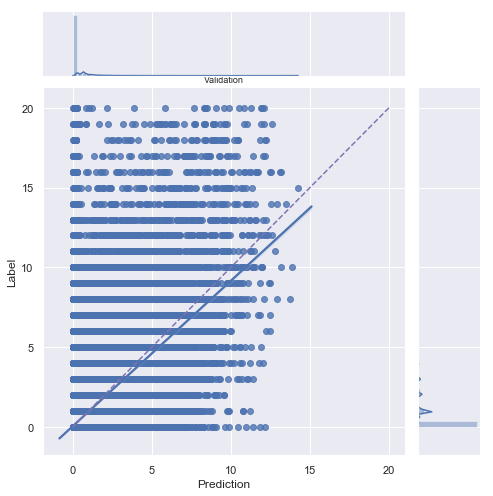

In [198]:
model_performance_sc_plot(lr_val_pred, Y_validation, 'Validation')

### Using Cross Validation

In [199]:
regressor=LinearRegression()
accuracies = cross_val_score(estimator = regressor, X = lr_train, y = Y_train, cv = 10)
print('Average Validation Accuracy is {}'.format(accuracies.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(accuracies.std()))

Average Validation Accuracy is 0.37592792057006463
Mean Standard Deviation in accuracies is 0.05806893013910034



### Using stratified K-fold Cross Validation

In [64]:
kfold = KFold(n_splits=2)
regressor=LinearRegression()
score=cross_val_score(regressor,X = lr_train, y = Y_train, cv=kfold)
print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.37197576549149813



### Finding Best Parameters using GridSearchCV and obtaining Test and Train Score

In [65]:
model = LinearRegression()
parameters = {'fit_intercept':[True,False], 'normalize':[True,False], 'copy_X':[True, False]}
grid = GridSearchCV(model,parameters, cv=10)
grid.fit(lr_train, Y_train)
print("Residual sum of squares: %.2f" % np.mean((grid.predict(lr_val) - Y_validation) ** 2))
print('Best Parameters {}'.format(grid.best_params_))
print('Train Score {}'.format(grid.score(lr_train,Y_train)))
print('Test Score {}'.format(grid.score(lr_test,Y_test)))

Residual sum of squares: 0.60
Best Parameters {'copy_X': True, 'fit_intercept': True, 'normalize': True}
Train Score 0.37375276823152415
Test Score 0.24958786951969403


## Ridge Regression

Fitting models with different values of alpha, and visualizing the train and test scores for different values of alpha

Text(0.5, 0, '$\\alpha$')

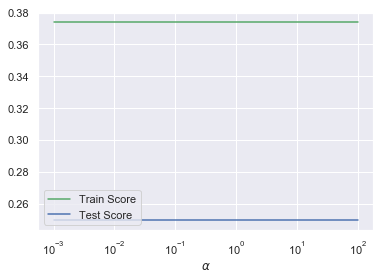

In [66]:
# Ridge uses L2 Penalty

# Defining values for hyperparameter alpha
alpha = [0.001,0.01, 0.1, 1, 10, 100]

train_score_list = []
test_score_list = []

# Fitting models for different values of alpha
for i in alpha: 
    ridge = Ridge()
    ridge.fit(lr_train,Y_train)
    train_score_list.append(ridge.score(lr_train,Y_train))
    test_score_list.append(ridge.score(lr_test, Y_test))

plt.plot(alpha, train_score_list, c = 'g', label = 'Train Score')
plt.plot(alpha, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

With Increase in alpha, Regularization increases and we can see in the graph, with increase in alpha model becomes more and more restricted, and leads to underfitting.
This graph suggests alpha=10 as optimal value as Train and Test Scores seem to dip after alpha=10.

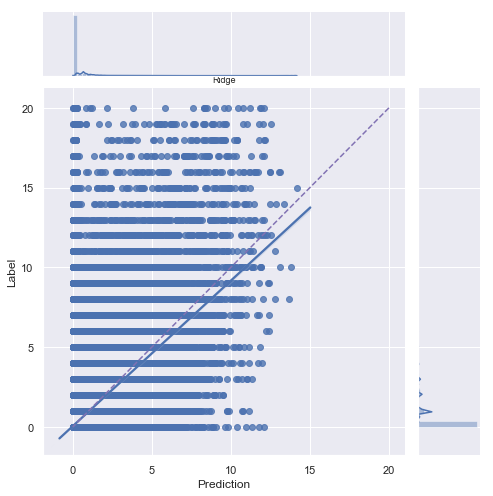

In [188]:
model_performance_sc_plot(ridge.predict(lr_val), Y_validation, 'Ridge')

### Finding the Best Parameter using Grid Search

In [68]:
# Applying Grid Search to find the best parameters
ridge=Ridge()
## We are creating a grid for which all n_neighbors values are to be used for cross validation
parameters = {'alpha':[0.001,0.01, 0.1, 1, 3, 5,10, 12,15,20, 100]}

## Using Grid search for exhaustive searching
grid_search = GridSearchCV(ridge,parameters,cv=10,return_train_score=True)

grid_search = grid_search.fit(lr_train, Y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy is {}'.format(best_accuracy))
print('Best Parameters {}'.format(best_parameters))

Best Accuracy is 0.3759495718590816
Best Parameters {'alpha': 20}


### Visualizing the results of grid search

In [69]:
# convert to DataFrame the results of grid search
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,0.72,0.02,0.03,0.00,0.00,{'alpha': 0.001},0.45,0.40,0.36,0.46,...,0.38,0.36,0.38,0.37,0.38,0.38,0.37,0.38,0.37,0.01
1,0.73,0.04,0.03,0.00,0.01,{'alpha': 0.01},0.45,0.40,0.36,0.46,...,0.38,0.36,0.38,0.37,0.38,0.38,0.37,0.38,0.37,0.01
2,0.72,0.02,0.03,0.00,0.10,{'alpha': 0.1},0.45,0.40,0.36,0.46,...,0.38,0.36,0.38,0.37,0.38,0.38,0.37,0.38,0.37,0.01
3,0.72,0.03,0.03,0.00,1,{'alpha': 1},0.45,0.40,0.36,0.46,...,0.38,0.36,0.38,0.37,0.38,0.38,0.37,0.38,0.37,0.01
4,0.73,0.03,0.03,0.00,3,{'alpha': 3},0.45,0.40,0.36,0.46,...,0.38,0.36,0.38,0.37,0.38,0.38,0.37,0.38,0.37,0.01


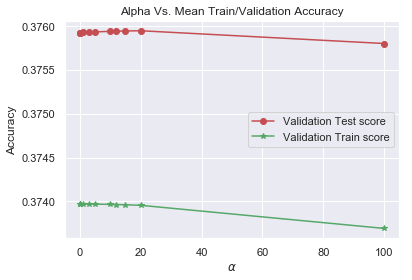

In [70]:
plt.plot(parameters['alpha'],results['mean_test_score'],marker='o',c='r',label='Validation Test score')
plt.plot(parameters['alpha'],results['mean_train_score'],marker='*',c='g',label='Validation Train score')
plt.title('Alpha Vs. Mean Train/Validation Accuracy')
plt.xlabel(r'$\alpha$')
plt.ylabel('Accuracy')
plt.legend()

### Applying Different Cross Validations using best parameters

#### Using Cross-Validation

In [71]:
ridge=Ridge(alpha=20)
accuracies = cross_val_score(estimator = ridge, X = lr_train, y = Y_train, cv = 10)
print('Average Validation Accuracy is {}'.format(accuracies.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(accuracies.std()))

Average Validation Accuracy is 0.3759495394484003
Mean Standard Deviation in accuracies is 0.05799490469228848



#### Using stratified K-fold Cross Validation

In [72]:
ridge=Ridge(alpha=20)
kfold = KFold(n_splits=3)
score=cross_val_score(ridge,X = lr_train, y = Y_train, cv=kfold)
print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.3736039373162617



#### Rebuilding the model on the best parameters found using Gridsearch

In [190]:
ridge = Ridge(alpha=20)
ridge.fit(lr_train, Y_train)
print('Train score on best parameters {}'.format(ridge.score(lr_train,Y_train)))
print('Test score on best parameters {}'.format(ridge.score(lr_test,Y_test)))
print('Validation score on best parameters {}'.format(ridge.score(lr_val,Y_validation)))
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,ridge.predict(lr_test))))

Train score on best parameters 0.37374096341946716
Test score on best parameters 0.24930563669524688
Validation score on best parameters 0.29919677364732433
Mean Squared Error : 0.6799816690538804


## Lasso Regression

Fitting models with different values of alpha, and visualizing the train and test scores for different values of alpha

Text(0.5, 0, '$\\alpha$')

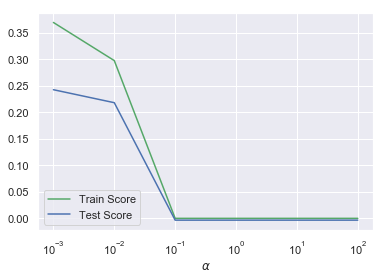

In [74]:
# Lasso uses L1 Penalty
# Defining values for hyperparameter alpha
alpha = [0.001,0.01, 0.1, 1, 10, 100]

train_score_list = []
test_score_list = []

# Fitting models for different values of alpha
for i in alpha: 
    lasso = Lasso(i)
    lasso.fit(lr_train,Y_train)
    train_score_list.append(lasso.score(lr_train,Y_train))
    test_score_list.append(lasso.score(lr_test, Y_test))

plt.plot(alpha, train_score_list, c = 'g', label = 'Train Score')
plt.plot(alpha, test_score_list, c = 'b', label = 'Test Score')
plt.xscale('log')
plt.legend(loc = 3)
plt.xlabel(r'$\alpha$')

The graph suggest alpha=0.001 as the optimal value.

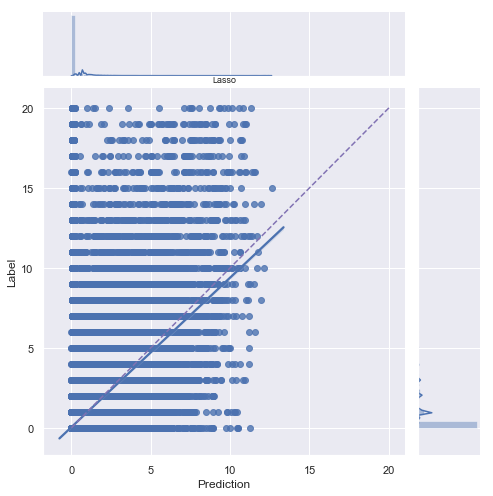

In [189]:
model_performance_sc_plot(lasso.predict(lr_val), Y_validation, 'Lasso')

### Finding Best Parameter using Grid Search

In [76]:
# Applying Grid Search to find the best parameters
lasso=Lasso()
## We are creating a grid for which all n_neighbors values are to be used for cross validation
parameters = {'alpha':[0.001,0.01, 0.1, 1, 3, 5,10, 12,15,20, 100], 'max_iter':[1000,5000,10000,20000]}

## Using Grid search for exhaustive searching
grid_search = GridSearchCV(lasso,parameters,cv=10,return_train_score=True)

grid_search = grid_search.fit(lr_train, Y_train)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy is {}'.format(best_accuracy))
print('Best Parameters {}'.format(best_parameters))

Best Accuracy is 0.37231244327401775
Best Parameters {'alpha': 0.001, 'max_iter': 1000}


### Visualizing the results of grid search

In [77]:
# convert to DataFrame the results of grid search
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_alpha,param_max_iter,params,split0_test_score,split1_test_score,split2_test_score,...,split2_train_score,split3_train_score,split4_train_score,split5_train_score,split6_train_score,split7_train_score,split8_train_score,split9_train_score,mean_train_score,std_train_score
0,1.96,0.07,0.03,0.00,0.00,1000,"{'alpha': 0.001, 'max_iter': 1000}",0.44,0.39,0.35,...,0.37,0.36,0.37,0.37,0.37,0.38,0.37,0.38,0.37,0.01
1,1.98,0.07,0.03,0.00,0.00,5000,"{'alpha': 0.001, 'max_iter': 5000}",0.44,0.39,0.35,...,0.37,0.36,0.37,0.37,0.37,0.38,0.37,0.38,0.37,0.01
2,1.96,0.05,0.03,0.00,0.00,10000,"{'alpha': 0.001, 'max_iter': 10000}",0.44,0.39,0.35,...,0.37,0.36,0.37,0.37,0.37,0.38,0.37,0.38,0.37,0.01
3,1.95,0.05,0.03,0.00,0.00,20000,"{'alpha': 0.001, 'max_iter': 20000}",0.44,0.39,0.35,...,0.37,0.36,0.37,0.37,0.37,0.38,0.37,0.38,0.37,0.01
4,1.29,0.04,0.03,0.01,0.01,1000,"{'alpha': 0.01, 'max_iter': 1000}",0.34,0.30,0.27,...,0.30,0.29,0.30,0.30,0.30,0.30,0.29,0.31,0.30,0.01


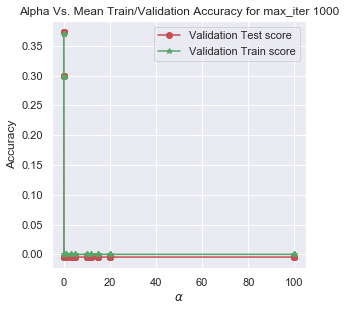

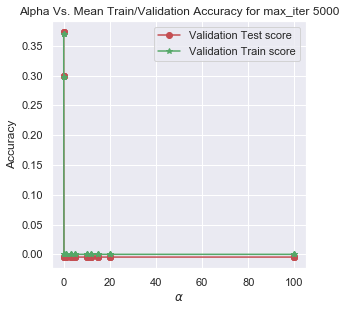

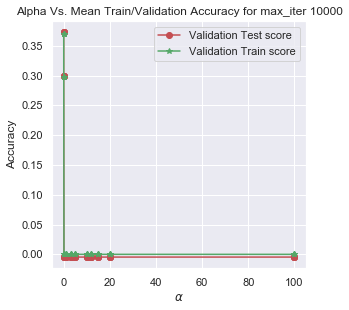

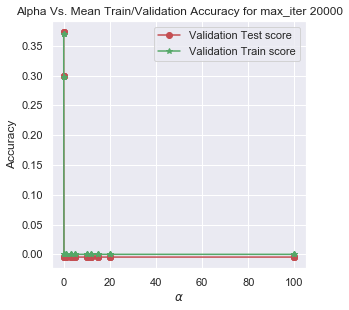

In [78]:
for i,j in zip(parameters['max_iter'],range(1,5)):
    plt.figure(figsize=(10,10))
    plt.subplot(2,2,j)
    plt.plot(results['param_alpha'],results['mean_test_score'],marker='o',c='r',label='Validation Test score')
    plt.plot(results['param_alpha'],results['mean_train_score'],marker='*',c='g',label='Validation Train score')
    plt.title('Alpha Vs. Mean Train/Validation Accuracy for max_iter {}'.format(i))
    plt.xlabel(r'$\alpha$')
    plt.ylabel('Accuracy')
    plt.legend()

### Applying Different Cross Validations using best parameters

#### Using Cross Validation

In [79]:
lasso=Lasso(alpha=0.001)
accuracies = cross_val_score(estimator = lasso, X = lr_train, y = Y_train, cv = 10)
print('Average Validation Accuracy is {}'.format(accuracies.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(accuracies.std()))

Average Validation Accuracy is 0.37231241171193447
Mean Standard Deviation in accuracies is 0.055437539472757064



#### Using stratified K-fold Cross Validation

In [80]:
lasso=Lasso(alpha=0.001)
kfold = KFold(n_splits=3)
score=cross_val_score(lasso,X = lr_train, y = Y_train, cv=kfold)
print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.36998054932202606



#### Rebuilding the model on the best parameters found using Gridsearch

In [191]:
lasso = Lasso(alpha=0.001)
lasso.fit(lr_train, Y_train)
print('Train score on best parameters {}'.format(lasso.score(lr_train,Y_train)))
print('Test score on best parameters {}'.format(lasso.score(lr_test,Y_test)))
print('Validation score on best parameters {}'.format(lasso.score(lr_val,Y_validation)))
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,lasso.predict(lr_test))))

Train score on best parameters 0.3695248554451339
Test score on best parameters 0.24268923610207127
Validation score on best parameters 0.29350000026243295
Mean Squared Error : 0.6859748286383892


# Polynomial Regression

In [207]:
lreg=LinearRegression()

train_score_list = []
test_score_list = []

for n in range(1,4):
    poly = PolynomialFeatures(n)  # n is the degree here, n=1 is same as linear regression
    X_train_poly = poly.fit_transform(lr_train)
    X_test_poly = poly.transform(lr_test)
    X_val_poly = poly.transform(lr_val)
    lreg.fit(X_train_poly, Y_train)
    train_score_list.append(lreg.score(X_train_poly, Y_train))
    test_score_list.append(lreg.score(X_test_poly, Y_test))

x_axis = range(1,4)
plt.plot(x_axis, train_score_list, c = 'g', label = 'Train Score')
plt.plot(x_axis, test_score_list, c = 'b', label = 'Test Score')
plt.xlabel('degree')
plt.ylabel('accuracy')
plt.legend()

MemoryError: 

Best performance is at degree 3

In [83]:
lreg=LinearRegression()
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(lr_train)
score = cross_val_score(estimator = lreg, X = X_train_poly, y = Y_train, cv = 10)

print('Average Validation Accuracy is {}'.format(score.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(score.std()))

Average Validation Accuracy is 0.38239652981088507
Mean Standard Deviation in accuracies is 0.05926415723709485



#### Using Cross Validation

In [84]:
poly = PolynomialFeatures(3)
X_train_poly = poly.fit_transform(lr_train)
lreg=LinearRegression()
score = cross_val_score(estimator = lreg, X = X_train_poly, y = Y_train, cv = 10)

print('Average Validation Accuracy is {}'.format(score.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(score.std()))

Average Validation Accuracy is 0.38239652981088507
Mean Standard Deviation in accuracies is 0.05926415723709485



#### Using stratified K-fold Cross validation

In [85]:
kfold = KFold(n_splits=3)
X_train_poly = poly.fit_transform(lr_train)
score = cross_val_score(estimator = lreg, X = X_train_poly, y = Y_train, cv = kfold)
print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.378438391344541



#### Building final model with best score

In [86]:
lreg=LinearRegression()
poly = PolynomialFeatures(3) 
X_train_poly = poly.fit_transform(lr_train)
X_test_poly = poly.transform(lr_test)
lreg.fit(X_train_poly, Y_train)
print('Train Score: {}'.format(lreg.score(X_train_poly,Y_train)))
print('Test Score: {}'.format(lreg.score(X_test_poly, Y_test)))
print('Validation Score: {}'.format(lreg.score(X_val_poly, Y_validation)))
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,lreg.predict(X_test_poly))))

Train Score: 0.38157017605308063
Test Score: 0.25790334072354626
Mean Squared Error : 0.6721938376527528


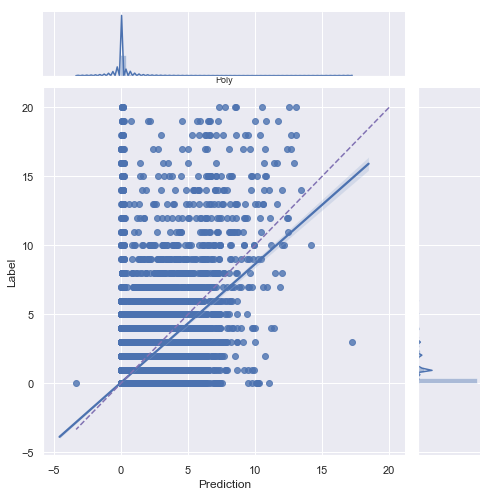

In [87]:
model_performance_sc_plot(lreg.predict(X_val_poly), Y_validation, 'Poly')

# Clustering Models

## KNN Regressor

In [229]:
# Use only part of features on KNN.
knn_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long and leading to memory error)
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

knn_train = X_train_sampled[knn_features]
knn_val = X_validation[knn_features]
knn_test = X_test[knn_features]

In [230]:
knn_val.replace(-np.inf, np.nan)

,item_cnt,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,shop_mean,shop_item_mean,item_trend,mean_item_cnt
0,1.00,1.00,0.00,1.00,1.00,0.10,0.84,-0.50,1.00
1,0.00,0.00,0.00,0.00,0.00,0.10,1.84,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.10,0.04,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.10,3.12,0.00,0.00
4,2.00,2.67,2.08,1.00,5.00,0.10,1.68,-1.50,1.00
5,0.00,0.00,0.00,0.00,0.00,0.10,1.48,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.10,0.80,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.10,0.04,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.10,0.64,0.00,0.00
9,2.00,1.67,0.58,1.00,2.00,0.10,3.92,-0.50,1.00


In [231]:
knn_val.replace(np.inf, np.nan)

,item_cnt,item_cnt_mean,item_cnt_std,item_cnt_shifted1,item_cnt_shifted2,shop_mean,shop_item_mean,item_trend,mean_item_cnt
0,1.00,1.00,0.00,1.00,1.00,0.10,0.84,-0.50,1.00
1,0.00,0.00,0.00,0.00,0.00,0.10,1.84,0.00,0.00
2,0.00,0.00,0.00,0.00,0.00,0.10,0.04,0.00,0.00
3,0.00,0.00,0.00,0.00,0.00,0.10,3.12,0.00,0.00
4,2.00,2.67,2.08,1.00,5.00,0.10,1.68,-1.50,1.00
5,0.00,0.00,0.00,0.00,0.00,0.10,1.48,0.00,0.00
6,0.00,0.00,0.00,0.00,0.00,0.10,0.80,0.00,0.00
7,0.00,0.00,0.00,0.00,0.00,0.10,0.04,0.00,0.00
8,0.00,0.00,0.00,0.00,0.00,0.10,0.64,0.00,0.00
9,2.00,1.67,0.58,1.00,2.00,0.10,3.92,-0.50,1.00


In [232]:
knn_val.fillna(0, inplace = True)

In [233]:
#Scaling the data
knn_scaler = MinMaxScaler()
knn_scaler.fit(knn_train)
knn_train = knn_scaler.transform(knn_train)
knn_val = knn_scaler.transform(knn_val)
knn_test = knn_scaler.transform(knn_test)

In [234]:
knn_model = KNeighborsRegressor(n_neighbors=9, leaf_size=13, n_jobs=-1)
knn_model.fit(knn_train, Y_train_sampled)

KNeighborsRegressor(algorithm='auto', leaf_size=13, metric='minkowski',
          metric_params=None, n_jobs=-1, n_neighbors=9, p=2,
          weights='uniform')

In [235]:
knn_train_pred = knn_model.predict(knn_train)
knn_test_pred = knn_model.predict(knn_test)
knn_val_pred = knn_model.predict(knn_val)

In [236]:
print('Train score:', np.sqrt(mean_squared_error(Y_train_sampled, knn_train_pred)))
print('Test score:', np.sqrt(mean_squared_error(Y_test, knn_test_pred)))
print('Validation score:', np.sqrt(mean_squared_error(Y_validation, knn_val_pred)))

Train score: 0.48661440612348666
Test score: 0.8421903357087696
Validation score: 0.80036105644979


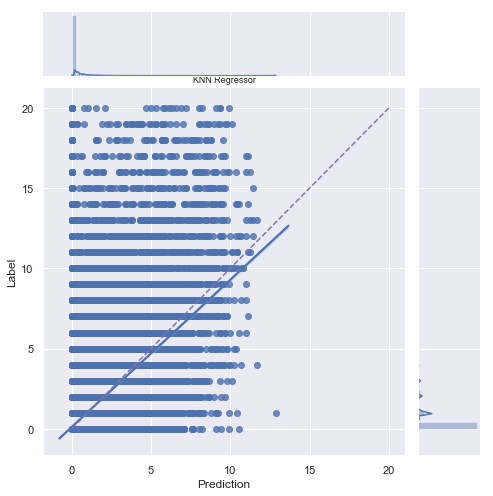

In [237]:
model_performance_sc_plot(knn_val_pred, Y_validation, 'KNN Regressor')

Mean squared error varying with k [0.9133473389355742, 0.8078944911297853, 0.7690196078431373, 0.7482215802987862, 0.7339639589169001, 0.7247316889718853, 0.7183698241201244, 0.7137689659197012, 0.7091431799057072, 0.7062315126050419, 0.7026118711947589, 0.7008499974063698, 0.6986521472494325, 0.6972544255797558]


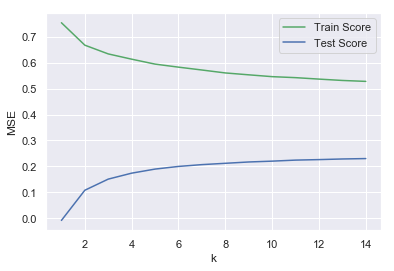

In [238]:
train_score_array = []
test_score_array = []
mean_squared=[]

for k in range(1,15):
    knn = KNeighborsRegressor(k)
    knn.fit(knn_train, Y_train_sampled)
    train_score_array.append(knn.score(knn_train, Y_train_sampled))
    test_score_array.append(knn.score(knn_test, Y_test))
    mean_squared.append(mean_squared_error(Y_test,knn.predict(knn_test)))

x_axis = range(1,15)
plt.plot(x_axis, train_score_array, c = 'g', label = 'Train Score')
plt.plot(x_axis, test_score_array, c = 'b', label = 'Test Score')
plt.legend()
plt.xlabel('k')
plt.ylabel('MSE')

print('Mean squared error varying with k {}'.format(mean_squared))

Finding the Best Parameter for KNN Regressor using Grid Search

In [240]:
# Applying Grid Search to find the best parameters
knn=KNeighborsRegressor()
## We are creating a grid for which all n_neighbors values are to be used for cross validation
parameters = {'n_neighbors': range(1,15)}
## Using Grid search for exhaustive searching
grid_search = GridSearchCV(knn,parameters,cv=3,return_train_score=True)

grid_search = grid_search.fit(knn_train, Y_train_sampled)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Cross ValidationAccuracy is {}'.format(best_accuracy))
print('Best Parameters {}'.format(best_parameters))
print('Test Score {}'.format(grid_search.score(knn_test,Y_test)))
print('Train Score {}'.format(grid_search.score(knn_train,Y_train_sampled)))

Best Cross ValidationAccuracy is 0.3962297759238778
Best Parameters {'n_neighbors': 14}
Test Score 0.23023665064338517
Train Score 0.5280230986157091


 ### Visualizing the results of grid search

In [241]:
# convert to DataFrame the results of grid search
results = pd.DataFrame(grid_search.cv_results_)
# show the first 5 rows
display(results.head())

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_neighbors,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,3.20,0.10,1.54,0.22,1,{'n_neighbors': 1},-0.28,-0.40,-0.11,-0.26,0.12,14,0.57,0.73,0.64,0.65,0.06
1,3.37,0.09,1.60,0.18,2,{'n_neighbors': 2},0.12,0.03,0.22,0.12,0.08,13,0.62,0.66,0.60,0.62,0.02
2,5.03,2.86,2.34,0.91,3,{'n_neighbors': 3},0.22,0.17,0.34,0.24,0.07,12,0.62,0.62,0.59,0.61,0.01
3,8.32,0.26,4.70,0.55,4,{'n_neighbors': 4},0.24,0.26,0.39,0.29,0.07,11,0.61,0.60,0.57,0.59,0.02
4,8.51,0.60,4.63,0.51,5,{'n_neighbors': 5},0.28,0.30,0.41,0.33,0.05,10,0.59,0.57,0.55,0.57,0.02


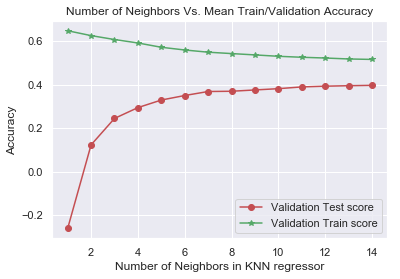

In [242]:
plt.plot(parameters['n_neighbors'],results['mean_test_score'],marker='o',c='r',label='Validation Test score')
plt.plot(parameters['n_neighbors'],results['mean_train_score'],marker='*',c='g',label='Validation Train score')
plt.title('Number of Neighbors Vs. Mean Train/Validation Accuracy')
plt.xlabel('Number of Neighbors in KNN regressor')
plt.ylabel('Accuracy')
plt.legend()

### Applying Different Cross Validations using best parameters

#### Using Cross-Validation

In [104]:
knn=KNeighborsRegressor(14)
accuracies = cross_val_score(estimator = knn, X = knn_train, y = Y_train_sampled, cv = 10)
print('Average Validation Accuracy is {}'.format(accuracies.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(accuracies.std()))

Average Validation Accuracy is 0.36517583109016916
Mean Standard Deviation in accuracies is 0.13887086388967335



#### Using stratified K-fold Cross Validation

In [105]:
kfold = KFold(n_splits=3)
knn=KNeighborsRegressor(14)
score=cross_val_score(knn,X = knn_train, y = Y_train_sampled, cv=kfold)
print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.39623020207125226



#### Rebuilding the model on the best parameters found using Gridsearch

In [243]:
knn = KNeighborsRegressor(**best_parameters)
knn.fit(knn_train, Y_train_sampled)
print('Train score on best parameters {}'.format(knn.score(knn_train,Y_train_sampled)))
print('Test score on best parameters {}'.format(knn.score(knn_test,Y_test)))
print('Validation score on best parameters {}'.format(knn.score(knn_val,Y_validation)))
grid_search.score(knn_test,Y_test)
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,knn.predict(knn_test))))

Train score on best parameters 0.5280230986157091
Test score on best parameters 0.23023665064338517
Validation score on best parameters 0.2671453110422578
Mean Squared Error : 0.6972544255797558


# SGD Regressor

In [248]:
# Use only part of features on SGD Regressor
sgdr_features = ['item_cnt', 'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1',
                'item_cnt_shifted2', 'shop_mean', 'shop_item_mean', 
                'item_trend', 'mean_item_cnt']

# Subsample train set (using the whole data was taking too long).
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

sgdr_train = X_train_sampled[sgdr_features]
sgdr_val = X_validation[sgdr_features]
sgdr_test = X_test[sgdr_features]

In [249]:
sgdr_val.replace(-np.inf, np.nan)
sgdr_val.replace(np.inf, np.nan)
sgdr_val.fillna(0, inplace=True)

In [250]:
#Scaling the data
sgdr_scaler = MinMaxScaler()
sgdr_scaler.fit(sgdr_train)
sgdr_train = sgdr_scaler.transform(sgdr_train)
sgdr_val = sgdr_scaler.transform(sgdr_val)
sgdr_test = sgdr_scaler.transform(sgdr_test)

## SGD Regressor using penalty l1

In [251]:
sgdr = SGDRegressor(random_state= 0, max_iter = 1000, penalty = 'l1')
sgdr.fit(sgdr_train, Y_train_sampled)
train=[]
test=[]
print('Train score for penalty l1 {}'.format(sgdr.score(sgdr_train, Y_train_sampled)))
print('Test score for penalty l1 {}'.format(sgdr.score(sgdr_test, Y_test)))
print('Validation score for penalty l1 {}'.format(sgdr.score(sgdr_val, Y_validation)))
train.append(sgdr.score(sgdr_train, Y_train_sampled))
test.append(sgdr.score(sgdr_test, Y_test))

Train score for penalty l1 0.4784193752240523
Test score for penalty l1 0.24924974749422665
Validation score for penalty l1 0.2957690915813652


## SGD Regressor using penalty l2

In [252]:
sgdr = SGDRegressor(random_state= 0, max_iter = 1000, penalty = 'l2')
sgdr.fit(sgdr_train, Y_train_sampled)
print('Train score for penalty l2 {}'.format(sgdr.score(sgdr_train, Y_train_sampled)))
print('Test score for penalty l2 {}'.format(sgdr.score(sgdr_test, Y_test)))
print('Validation score for penalty l2 {}'.format(sgdr.score(sgdr_val, Y_validation)))
train.append(sgdr.score(sgdr_train, Y_train_sampled))
test.append(sgdr.score(sgdr_test, Y_test))

Train score for penalty l2 0.4773486083751391
Test score for penalty l2 0.24876965925492586
Validation score for penalty l2 0.29408271441264344


### Finding Best parameter using Grid Search

In [114]:
# Applying Grid Search to find the best parameters
sgdr = SGDRegressor(max_iter=1000)
## We are creating a grid for which all n_neighbors values are to be used for cross validation
parameters = {'penalty':['l1','l2','elasticnet'],'learning_rate':['constant','optimal','invscaling']}
## Using Grid search for exhaustive searching
grid_search = GridSearchCV(sgdr,parameters,cv=10,return_train_score=True)
grid_search = grid_search.fit(sgdr_train, Y_train_sampled)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

print('Best Accuracy is {}'.format(best_accuracy))
print('Best Parameters {}'.format(best_parameters))

Best Accuracy is 0.40364949864716865
Best Parameters {'learning_rate': 'invscaling', 'penalty': 'elasticnet'}


### Let's Fit the model with best parameters

In [253]:
sgdr = SGDRegressor(random_state= 0, max_iter = 1000,learning_rate='invscaling' ,penalty = 'elasticnet')
sgdr.fit(sgdr_train, Y_train_sampled)
print('Train score for penalty elasticnet {}'.format(sgdr.score(sgdr_train, Y_train_sampled)))
print('Test score for penalty elasticnet {}'.format(sgdr.score(sgdr_test, Y_test)))
print('Validation score for penalty elasticnet {}'.format(sgdr.score(sgdr_val, Y_validation)))
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,sgdr.predict(sgdr_test))))

Train score for penalty elasticnet 0.4775816968912625
Test score for penalty elasticnet 0.24885238445171143
Validation score for penalty elasticnet 0.294325467683487
Mean Squared Error : 0.6803922265751928


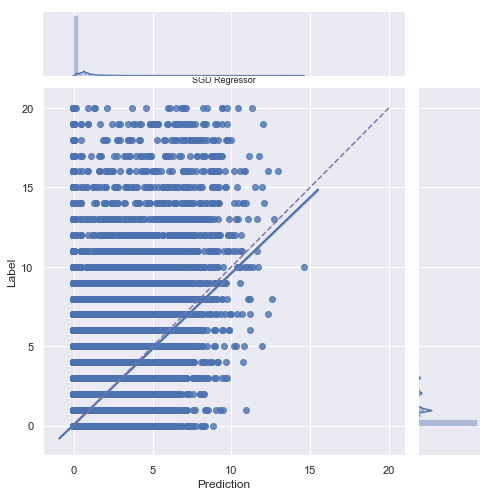

In [254]:
model_performance_sc_plot(sgdr.predict(sgdr_val), Y_validation, 'SGD Regressor')

# Decision Tree Regressor

In [255]:
# Subsample train set 
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

dt_train = X_train_sampled
dt_val = X_validation
dt_test = X_test

In [256]:
dt_val.replace(-np.inf, np.nan)
dt_val.replace(np.inf, np.nan)
dt_val.fillna(0, inplace=True)

In [257]:
#Scaling the data
dt_scaler = MinMaxScaler()
dt_scaler.fit(dt_train)
dt_train = dt_scaler.transform(dt_train)
dt_val = dt_scaler.transform(dt_val)
dt_test = dt_scaler.transform(dt_test)

In [258]:
dtr=DecisionTreeRegressor()
dtr.fit(dt_train,Y_train_sampled)
print('Train Score {}'.format(dtr.score(dt_train,Y_train_sampled)))
print('Test Score {}'.format(dtr.score(dt_test,Y_test)))
print('Validation Score {}'.format(dtr.score(dt_val,Y_validation)))

Train Score 1.0
Test Score -0.1323701187912829
Validation Score -0.1767946498947224


#### Using Grid Search to find the best parameters

In [121]:
dtr=DecisionTreeRegressor()
parameters={'max_depth':[2,5,10,20,50,100], 'min_samples_split':[2,10,20,50,100],'max_leaf_nodes':[30,100,150,200,300,400,500,700,800]}
grid_search = GridSearchCV(dtr,parameters,cv=10,return_train_score=True)
grid_search = grid_search.fit(dt_train, Y_train_sampled)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

In [122]:
print('Best Accuracy is {}'.format(best_accuracy))
print('Best Parameters {}'.format(best_parameters))

Best Accuracy is 0.4718133331659458
Best Parameters {'max_depth': 50, 'max_leaf_nodes': 30, 'min_samples_split': 10}


#### Visualizing the results

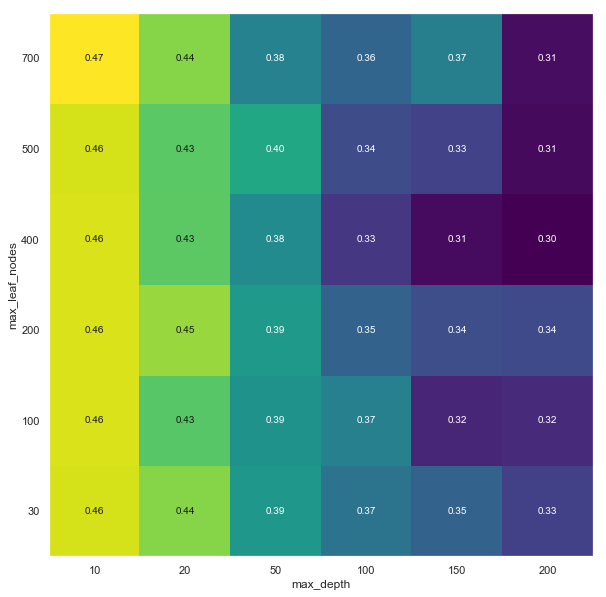

In [124]:
dtr=DecisionTreeRegressor(min_samples_split=2)
parameters={'max_depth':[10,20,50,100,150,200],'max_leaf_nodes':[30,100,200,400,500,700]}
grid_search = GridSearchCV(dtr,parameters,cv=10,return_train_score=True)
grid_search = grid_search.fit(dt_train, Y_train_sampled)

best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(6, 6)
plt.figure(figsize=(10,10))
mglearn.tools.heatmap(scores, xlabel='max_depth', xticklabels=parameters['max_depth'], ylabel='max_leaf_nodes', yticklabels=parameters['max_leaf_nodes'], cmap="viridis")

#### Fitting tree with best parameters

In [259]:
dtr=DecisionTreeRegressor(max_depth=50, max_leaf_nodes=30, min_samples_split=2)
dtr.fit(dt_train,Y_train_sampled)
print('Train Score {}'.format(dtr.score(dt_train,Y_train_sampled)))
print('Test Score {}'.format(dtr.score(dt_test,Y_test)))
print('Validation Score {}'.format(dtr.score(dt_val,Y_validation)))
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,dtr.predict(dt_test))))

Train Score 0.6311872353785728
Test Score 0.11417049027002579
Validation Score 0.14946093579082254
Mean Squared Error : 0.8023875733816297


#### Visualizing Feature Importances

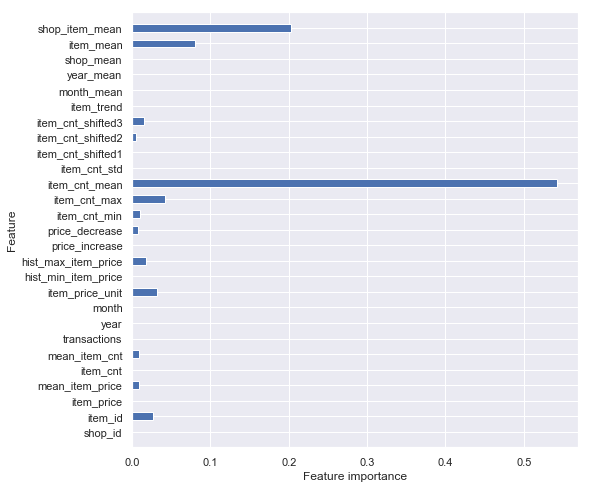

In [127]:
cols=X_train_sampled.columns.values
def plot_feature_importances(model):
    plt.figure(figsize=(8,8))
    n_features = X_train_sampled.shape[1]
    plt.barh(range(n_features), model.feature_importances_, height=0.5,align='center')
    plt.yticks(np.arange(n_features), cols)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(dtr)

#### Using Cross Validation

In [128]:
dtr=DecisionTreeRegressor(max_depth=100, max_leaf_nodes=100, min_samples_split=2)
score = cross_val_score(estimator = dtr, X = dt_train, y = Y_train_sampled, cv = 10)
print('Average Validation Accuracy is {}'.format(score.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(score.std()))

Average Validation Accuracy is 0.43255351212047344
Mean Standard Deviation in accuracies is 0.17985114434188068



#### Using K-fold Cross Validation

In [129]:
kfold = KFold(n_splits=10)
dtr=DecisionTreeRegressor(max_depth=100, max_leaf_nodes=100, min_samples_split=2)
score = cross_val_score(estimator = dtr, X = dt_train, y = Y_train_sampled, cv = kfold)
print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.42837931132304174



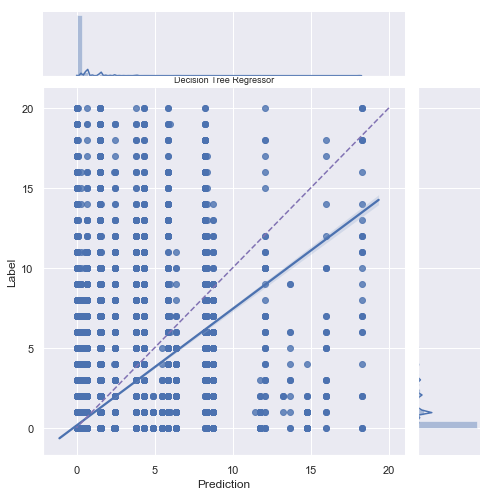

In [260]:
model_performance_sc_plot(dtr.predict(dt_val), Y_validation, 'Decision Tree Regressor')

# Random Forest

In [261]:
# Subsample train set 
X_train_sampled = X_train[:100000]
Y_train_sampled = Y_train[:100000]

#Subsample features
rf_features = ['shop_id', 'item_id', 'item_cnt', 'transactions', 'year',
               'item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
               'shop_mean', 'item_mean', 'item_trend', 'mean_item_cnt']

rf_train = X_train_sampled[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [262]:
rf_val.replace(-np.inf, np.nan)
rf_val.replace(np.inf, np.nan)
rf_val.fillna(0, inplace=True)

In [263]:
rf = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0, n_jobs=-1)
rf.fit(rf_train, Y_train_sampled)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=7,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [264]:
rf_train_pred = rf.predict(rf_train)
rf_val_pred = rf.predict(rf_val)
rf_test_pred = rf.predict(rf_test)

In [265]:
print('Train score:', np.sqrt(mean_squared_error(Y_train_sampled, rf_train_pred)))
print('Test score:', np.sqrt(mean_squared_error(Y_test, rf_test_pred)))
print('Validation score:', np.sqrt(mean_squared_error(Y_validation, rf_val_pred)))

Train score: 0.4102120722227434
Test score: 0.8490400608377772
Validation score: 0.8043960966706822


Best Accuracy is 0.5376702801054948
Best Parameters {'max_depth': 15, 'n_estimators': 40}


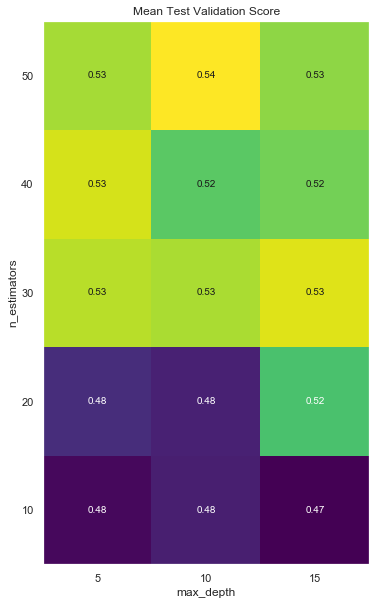

In [266]:
rf= RandomForestRegressor()
parameters={'max_depth':[5,10,15], 'n_estimators':[10,20,30,40,50]}
grid_search = GridSearchCV(rf,parameters,cv=5,return_train_score=True)
grid_search = grid_search.fit(rf_train, Y_train_sampled)
best_accuracy = grid_search.best_score_
best_parameters = grid_search.best_params_
print('Best Accuracy is {}'.format(best_accuracy))
print('Best Parameters {}'.format(best_parameters))

results = pd.DataFrame(grid_search.cv_results_)
scores = np.array(results.mean_test_score).reshape(5, 3)
plt.figure(figsize=(10,10))
plt.title('Mean Test Validation Score')
mglearn.tools.heatmap(scores, xlabel='max_depth', xticklabels=parameters['max_depth'], ylabel='n_estimators', yticklabels=parameters['n_estimators'], cmap="viridis")

we have found best parameters as max_depth=15 and number of tress in our forest =50

#### Building Model with best parameters

In [267]:
rf= RandomForestRegressor(max_depth=15,n_estimators=50)
rf.fit(rf_train,Y_train_sampled)

print('Train Score {}'.format(rf.score(rf_train,Y_train_sampled)))
print('Test Score {}'.format(rf.score(rf_test,Y_test)))
print('Validation Score {}'.format(rf.score(rf_val,Y_validation)))
print('Mean Squared Error : {}'.format(mean_squared_error(Y_test,rf.predict(rf_test))))

Train Score 0.882872387866381
Test Score 0.13543143343637598
Validation Score 0.17303058009679673
Mean Squared Error : 0.7831293341745699


#### Using Cross Validation

In [162]:
rf= RandomForestRegressor(max_depth=15,n_estimators=50)
score = cross_val_score(estimator = rf, X = rf_train, y = Y_train_sampled, cv = 10)

print('Average Validation Accuracy is {}'.format(score.mean()))
print('Mean Standard Deviation in accuracies is {}\n'.format(score.std()))

Average Validation Accuracy is 0.41312671721828753
Mean Standard Deviation in accuracies is 0.24038199268963503



#### Using Stratified Cross Validation

In [163]:
kfold = KFold(n_splits=10)
rf= RandomForestRegressor(max_depth=15,n_estimators=50)
score = cross_val_score(estimator = rf, X = rf_train, y = Y_train_sampled, cv = kfold)

print('Average Cross-validation score:{}\n'.format(score.mean()))

Average Cross-validation score:0.430203973131552



#### Feature Importance

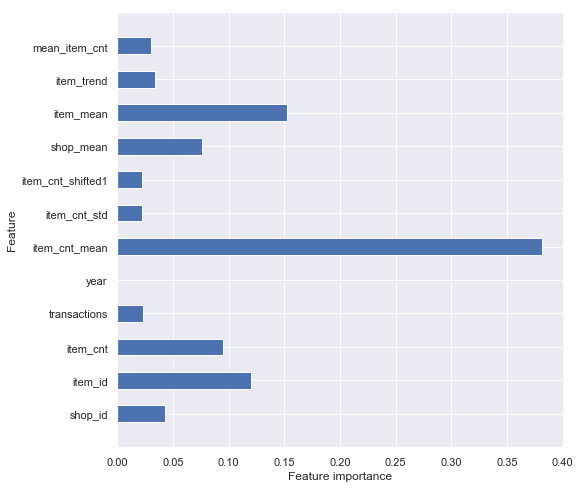

In [165]:
rf= RandomForestRegressor(max_depth=15,n_estimators=50)
rf.fit(rf_train,Y_train_sampled)
cols=rf_train.columns.values
def plot_feature_importances(model):
    plt.figure(figsize=(8,8))
    n_features = rf_train.shape[1]
    plt.barh(range(n_features), model.feature_importances_, height=0.5,align='center')
    plt.yticks(np.arange(n_features), cols)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

plot_feature_importances(rf)

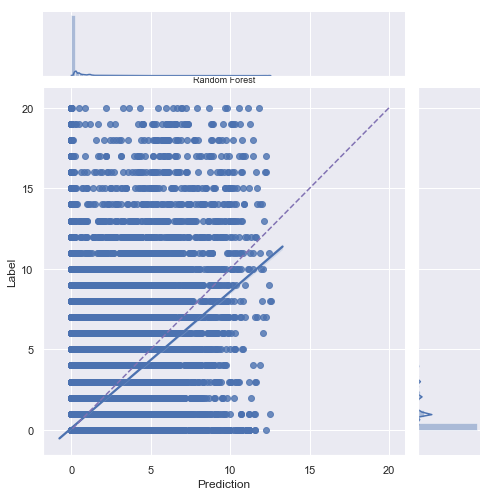

In [171]:
model_performance_sc_plot(rf_val_pred, Y_validation, 'Random Forest')

# XGBoost

In [177]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_mean', 'item_cnt_std', 'item_cnt_shifted1', 
                'item_cnt_shifted2', 'item_cnt_shifted3', 'shop_mean', 
                'shop_item_mean', 'item_trend', 'mean_item_cnt']

xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [179]:
xgb_model = XGBRegressor(max_depth=8, 
                         n_estimators=500, 
                         min_child_weight=1000,  
                         colsample_bytree=0.7, 
                         subsample=0.7, 
                         eta=0.3, 
                         seed=0)
xgb_model.fit(xgb_train, 
              Y_train, 
              eval_metric="rmse", 
              eval_set=[(xgb_train, Y_train), (xgb_val, Y_validation)], 
              verbose=20, 
              early_stopping_rounds=20)

[13:12:54] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[13:12:54] WARNING: C:\Jenkins\workspace\xgboost-win64_release_0.90\src\learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:0.937942	validation_1-rmse:0.928302
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 20 rounds.
[20]	validation_0-rmse:0.682448	validation_1-rmse:0.803103
Stopping. Best iteration:
[16]	validation_0-rmse:0.688665	validation_1-rmse:0.801072



XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
       importance_type='gain', learning_rate=0.1, max_delta_step=0,
       max_depth=8, min_child_weight=1000, missing=None, n_estimators=500,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0, silent=None,
       subsample=0.7, verbosity=1)

In [180]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [181]:
print('Train score:', np.sqrt(mean_squared_error(Y_train, xgb_train_pred)))
print('Test score:', np.sqrt(mean_squared_error(Y_test, xgb_test_pred)))
print('Validation score:', np.sqrt(mean_squared_error(Y_validation, xgb_val_pred)))

Train score: 0.6934685873930606
Test score: 0.8482454212143807
Validation score: 0.8025170994387208


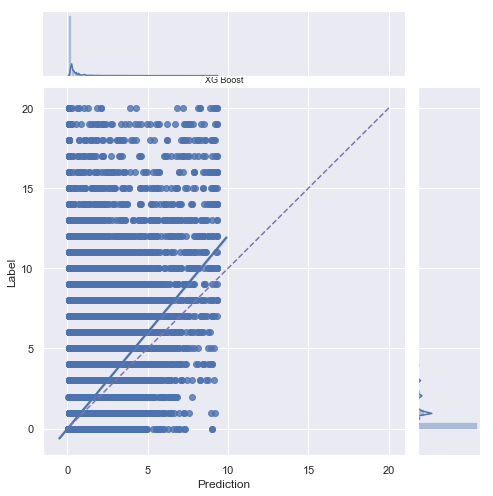

In [182]:
model_performance_sc_plot(xgb_val_pred, Y_validation, 'XG Boost')

# Tabulating predictive performances of all the models

In [270]:
results = pd.read_csv('../Data/model_results.csv')
results

,Model,Train Score,Test Score,Validation Accuracy,Best Parameters
0,Linear Regression,0.73,0.82,0.78,"'copy_X': True, 'fit_intercept': True, 'normal..."
1,Ridge Regression,0.37,0.25,0.30,'alpha': 20
2,Lasso Regression,0.37,0.24,0.29,"'alpha': 0.001, 'max_iter': 1000"
3,Polynomial Regression,0.38,0.26,0.38,No hyperparameter
4,KNN Regressor,0.53,0.23,0.27,'n_neighbors': 14
5,SGD Regressor,0.48,0.25,0.29,"'learning_rate': 'invscaling', 'penalty': 'ela..."
6,Decision Tree Regressor,0.63,0.11,0.15,"max_depth': 50, 'max_leaf_nodes': 30, 'min_sam..."
7,Random Forest,0.88,0.14,0.17,"'max_depth': 15, 'n_estimators': 50"
8,XG Boost,0.69,0.85,0.80,No hyperparameters tuned


# Ensemble Model

The predictions of models we have run so far can be used as the input for an ensemble model. 

In [280]:
# Dataset that will be the train set of the ensemble model
initial_predictions = pd.DataFrame(lr_val_pred, columns=['linear_reg'])
initial_predictions['knn'] = knn_val_pred
initial_predictions['random_forest'] = rf_val_pred
initial_predictions['xgb'] = xgb_val_pred
initial_predictions['label'] = Y_validation.values
initial_predictions.head(20)

,linear_reg,knn,random_forest,xgb,label
0,0.60,1.00,0.96,0.78,0
1,0.04,0.78,0.25,0.71,0
2,0.04,0.00,0.06,0.12,0
3,0.04,0.11,1.00,0.91,4
4,1.46,0.67,2.21,1.62,1
5,0.04,0.11,0.31,0.71,1
6,0.04,0.11,0.06,0.47,0
7,0.04,0.00,0.01,0.12,1
8,0.04,0.11,0.10,0.41,0
9,1.15,2.89,1.35,1.99,2


In [281]:
# Dataset that will be the test set of the ensemble model
initial_predictions_test = pd.DataFrame(lr_test_pred, columns=['linear_reg'])
initial_predictions_test['knn'] = knn_test_pred
initial_predictions_test['random_forest'] = rf_test_pred
initial_predictions_test['xgb'] = xgb_test_pred
initial_predictions_test.head(20)

,linear_reg,knn,random_forest,xgb
0,0.85,0.89,1.09,0.36
1,0.22,0.00,0.07,0.19
2,1.79,1.11,0.47,0.41
3,0.06,0.00,0.00,0.09
4,0.22,0.00,0.07,0.19
5,1.00,0.78,1.11,0.49
6,1.29,0.78,0.70,0.48
7,0.06,0.33,0.07,0.25
8,2.07,1.56,2.03,1.23
9,0.06,0.00,0.00,0.09


In [282]:
ensemble_model = LinearRegression(n_jobs=-1)

In [283]:
# Drop label from dataset.
initial_predictions.drop('label', axis=1, inplace=True)
ensemble_model.fit(initial_predictions, Y_validation)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=-1, normalize=False)

In [284]:
ensemble_predictions = ensemble_model.predict(initial_predictions)
final_predictions = ensemble_model.predict(initial_predictions_test)

In [287]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_predictions, Y_validation)))

Train rmse: 0.7672951292907008


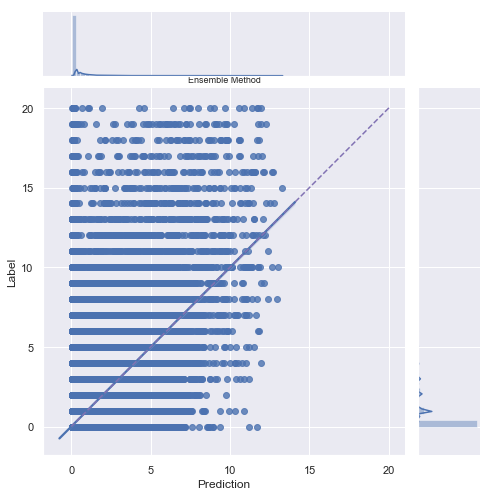

In [288]:
model_performance_sc_plot(ensemble_predictions, Y_validation, 'Ensemble Method')